#  Library Book Borrowing - Clustering Analysis


##  Cell 1: Import Libraries

**What this does:** Load all the tools we need for analysis

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# - Preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder

#- Clustering
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

#- Evaluation
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Dimensionality Reduction (for visualization)
from sklearn.decomposition import PCA

# Settings
import warnings
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print(" All libraries imported successfully!")

 All libraries imported successfully!


---
##  Cell 2: Load the Data

**What this does:** Read the CSV file and explore its structure

In [2]:
# Load the data
df = pd.read_csv('../data/unified_library_with_topics_isbn.csv')

# Display basic information
print("="*70)
print("DATASET OVERVIEW")
print("="*70)
print(f"Total records: {len(df)}")
print(f"Total columns: {len(df.columns)}")
print(f"\nColumn names:")
print(df.columns.tolist())

# Show first few rows
print("\n" + "="*70)
print("FIRST 5 ROWS")
print("="*70)
df.head()

DATASET OVERVIEW
Total records: 422
Total columns: 36

Column names:
['Numéro', 'Cote_borrowings', 'Titre', 'Type de document', 'N° lecteur', 'Nom', 'Prénom', 'Catégorie', 'borrowing duration', 'ISBN, ISSN...', 'Auteur_merged1', 'Cote_catalogue', 'Nbr. Exp.', 'Total_Copies', 'First_Acquisition', 'Copy_Statuses', 'Titre.1', 'Auteur_inventory', 'Editeur', "Date d'édition", "Lieu d'édition", 'Edition', "Mode d'acquisition", 'Fournisseur', 'N° achat', 'Prix', 'Cote', 'Localisation', 'Observation', 'cote_digits', 'topic_fr', 'isbn_clean', 'isbn_type', 'isbn_country', 'isbn_group_digit', 'isbn_country_fr']

FIRST 5 ROWS


,Numéro,Cote_borrowings,Titre,Type de document,N° lecteur,Nom,Prénom,Catégorie,borrowing duration,"ISBN, ISSN...",...,Cote,Localisation,Observation,cote_digits,topic_fr,isbn_clean,isbn_type,isbn_country,isbn_group_digit,isbn_country_fr
0,1000,515 MON,Exercices corrigés d'analyse : 1ère année LMD,Livre,5817912,MAMECHE,FERIEL,1 ére ANNEE,15,9789961652855,...,515 MON,ENSIA,NaN,515.0,Analyse / calcul,9789961652855,ISBN-13,Scandinavie / autres,9.0,Pays scandinaves / autres
1,1005,510.BAL/1,Exercices d'algèbre et d'analyse : 154 exercic...,Livre,5754033,fourali,malak,1 ére ANNEE,17,9789931926221,...,510.BAL/1,NaN,NaN,510.0,Mathématiques générales,9789931926221,ISBN-13,Scandinavie / autres,9.0,Pays scandinaves / autres
2,1006,510.BAL/2,Exercices d'algèbre et d'analyse : 154 exercic...,Livre,5113394,SEHALI,MAYA,1 ére ANNEE,15,9789931926221,...,510.BAL/1,NaN,NaN,510.0,Mathématiques générales,9789931926221,ISBN-13,Scandinavie / autres,9.0,Pays scandinaves / autres
3,1007,510.BAL/3,Exercices d'algèbre et d'analyse : 154 exercic...,Livre,6092419,kheddaoui,thiziri,1 ére ANNEE,15,9789931926221,...,510.BAL/1,NaN,NaN,510.0,Mathématiques générales,9789931926221,ISBN-13,Scandinavie / autres,9.0,Pays scandinaves / autres
4,1009,518.107.BAY/1,Exercices et problèmes d'algorithmique : 144 é...,Livre,8354464,GACEB,RIHAM BAHIA,3 ème ANNEE,7,2100069586,...,518.107.BAY/1,ENSIA,NaN,518.0,Méthodes numériques / calcul scientifique,2100069586,ISBN-10,Francophone,2.0,Pays francophones


---
##  Cell 3: Explore the Data

**What this does:** Understand what we're working with

In [3]:
# Key statistics
print("="*70)
print("KEY STATISTICS")
print("="*70)

print(f"\n Unique students: {df['N° lecteur'].nunique()}")
print(f" Total borrowing records: {len(df)}")
print(f"  Unique book topics: {df['topic_fr'].nunique()}")

print("\n" + "="*70)
print("STUDENT CATEGORIES")
print("="*70)
print(df['Catégorie'].value_counts())

print("\n" + "="*70)
print("TOP 10 BOOK TOPICS")
print("="*70)
print(df['topic_fr'].value_counts().head(10))

print("\n" + "="*70)
print("BORROWING DURATION STATISTICS")
print("="*70)
print(df['borrowing duration'].describe())

KEY STATISTICS

 Unique students: 271
 Total borrowing records: 422
  Unique book topics: 22

STUDENT CATEGORIES
Catégorie
1 ére ANNEE    199
2 éme ANNEE    132
3 ème ANNEE     49
4 éme ANNEE     21
Enseignant      19
Employé          2
Name: count, dtype: int64

TOP 10 BOOK TOPICS
topic_fr
Algèbre                                               147
Analyse / calcul                                      102
Programmation / logiciels                              46
Probabilités et statistiques appliquées                35
Mathématiques générales                                27
Informatique générale                                  19
Intelligence artificielle / traitement automatique     11
Principes généraux des maths                            9
Génie / ingénierie                                      5
Inconnu                                                 4
Name: count, dtype: int64

BORROWING DURATION STATISTICS
count    422.000000
mean      16.270142
std       20.121909
min        

---
##  Cell 4: FEATURE ENGINEERING - Convert Strings to Numbers

**What this does:** Transform raw borrowing records into student-level numeric features

**Key concept:** Clustering needs numbers, not text! We'll create features like:
- How many books each student borrowed
- Average borrowing duration
- Books borrowed per topic
- Topic diversity

In [4]:
print(" Creating student-level features...\n")

# List to store features for each student
student_features = []

# Process each student
for student_id in df['N° lecteur'].unique():
    # Get all records for this student
    student_data = df[df['N° lecteur'] == student_id]
    
    # ========================================
    # Basic borrowing statistics (NUMERIC)
    # ========================================
    total_books = len(student_data)
    avg_duration = student_data['borrowing duration'].mean()
    max_duration = student_data['borrowing duration'].max()
    
    # ========================================
    # Topic diversity (NUMERIC)
    # ========================================
    unique_topics = student_data['topic_fr'].nunique()
    
    # ========================================
    # Count books per topic (STRING → NUMBER)
    # ========================================
    topic_counts = student_data['topic_fr'].value_counts()
    
    # ========================================
    # Get student category (STRING → will encode later)
    # ========================================
    student_category = student_data['Catégorie'].iloc[0]
    
    # Create feature dictionary
    features = {
        'student_id': student_id,
        'total_books_borrowed': total_books,
        'avg_borrowing_duration': avg_duration,
        'max_borrowing_duration': max_duration,
        'topic_diversity': unique_topics,
        'student_category': student_category
    }
    
    # Add topic-specific counts (STRING TOPICS → NUMERIC COUNTS)
    for topic in df['topic_fr'].unique():
        if topic in topic_counts:
            features[f'books_{topic}'] = topic_counts[topic]
        else:
            features[f'books_{topic}'] = 0  # Student didn't borrow this topic
    
    student_features.append(features)

# Convert to DataFrame
student_df = pd.DataFrame(student_features)

print(f" Created {len(student_df)} student records")
print(f" Total features: {len(student_df.columns)}")
print(f"\nFirst 5 students:")
student_df.head()

 Creating student-level features...

 Created 271 student records
 Total features: 28

First 5 students:


,student_id,total_books_borrowed,avg_borrowing_duration,max_borrowing_duration,topic_diversity,student_category,books_Analyse / calcul,books_Mathématiques générales,books_Méthodes numériques / calcul scientifique,books_Algèbre,...,books_Gestion / management,books_Maladies / pathologie,books_Médecine / santé,books_Sciences de la vie / biologie,books_Techniques d’écriture / composition,books_Anatomie,books_Commerce / communication,books_Administration publique,books_Psychologie,books_Appareils de précision / informatique appliquée
0,5817912,3,15.0,15,2,1 ére ANNEE,1,0,0,2,...,0,0,0,0,0,0,0,0,0,0
1,5754033,3,17.0,17,3,1 ére ANNEE,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,5113394,2,15.0,15,2,1 ére ANNEE,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3,6092419,2,15.0,15,2,1 ére ANNEE,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,8354464,2,7.0,7,2,3 ème ANNEE,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


---
##  Cell 5: Visualize Feature Distribution

**What this does:** See the distribution of our numeric features

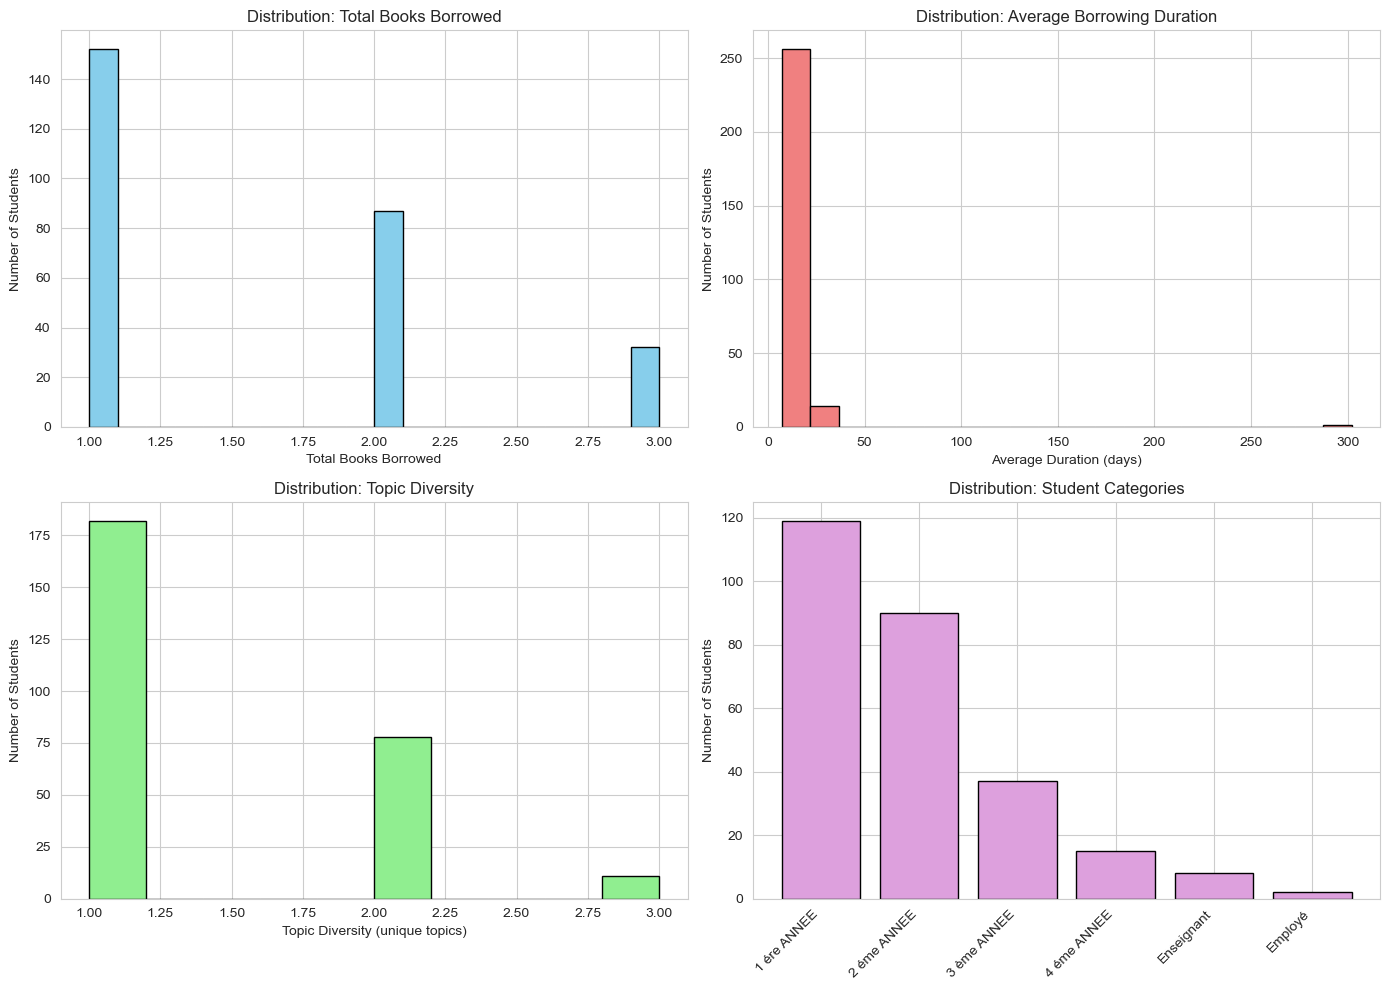

 Feature distributions plotted!


In [5]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Total books borrowed
axes[0, 0].hist(student_df['total_books_borrowed'], bins=20, color='skyblue', edgecolor='black')
axes[0, 0].set_xlabel('Total Books Borrowed')
axes[0, 0].set_ylabel('Number of Students')
axes[0, 0].set_title('Distribution: Total Books Borrowed')

# 2. Average borrowing duration
axes[0, 1].hist(student_df['avg_borrowing_duration'], bins=20, color='lightcoral', edgecolor='black')
axes[0, 1].set_xlabel('Average Duration (days)')
axes[0, 1].set_ylabel('Number of Students')
axes[0, 1].set_title('Distribution: Average Borrowing Duration')

# 3. Topic diversity
axes[1, 0].hist(student_df['topic_diversity'], bins=10, color='lightgreen', edgecolor='black')
axes[1, 0].set_xlabel('Topic Diversity (unique topics)')
axes[1, 0].set_ylabel('Number of Students')
axes[1, 0].set_title('Distribution: Topic Diversity')

# 4. Student categories
category_counts = student_df['student_category'].value_counts()
axes[1, 1].bar(range(len(category_counts)), category_counts.values, color='plum', edgecolor='black')
axes[1, 1].set_xticks(range(len(category_counts)))
axes[1, 1].set_xticklabels(category_counts.index, rotation=45, ha='right')
axes[1, 1].set_ylabel('Number of Students')
axes[1, 1].set_title('Distribution: Student Categories')

plt.tight_layout()
plt.show()

print(" Feature distributions plotted!")

---
##  Cell 6: Prepare Features for Clustering

**What this does:** Select only numeric features and handle missing values

In [6]:
print(" Preparing features for clustering...\n")

# Select only NUMERIC features (exclude student_id and student_category)
feature_columns = [col for col in student_df.columns 
                   if col not in ['student_id', 'student_category']]

print(f"Selected {len(feature_columns)} numeric features:")
for i, col in enumerate(feature_columns[:10], 1):
    print(f"  {i}. {col}")
print(f"  ... and {len(feature_columns) - 10} more")

# Extract feature matrix
X = student_df[feature_columns].values
student_ids = student_df['student_id'].values

print(f"\n Feature matrix shape: {X.shape}")
print(f"   ({X.shape[0]} students × {X.shape[1]} features)")

# Check for missing or invalid values
print(f"\n🔍 Data quality check:")
print(f"   NaN values: {np.isnan(X).sum()}")
print(f"   Infinite values: {np.isinf(X).sum()}")

# Replace any NaN or infinite values with 0
X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
print(f"\n Data cleaned!")

 Preparing features for clustering...

Selected 26 numeric features:
  1. total_books_borrowed
  2. avg_borrowing_duration
  3. max_borrowing_duration
  4. topic_diversity
  5. books_Analyse / calcul
  6. books_Mathématiques générales
  7. books_Méthodes numériques / calcul scientifique
  8. books_Algèbre
  9. books_Inconnu
  10. books_Programmation / logiciels
  ... and 16 more

 Feature matrix shape: (271, 26)
   (271 students × 26 features)

🔍 Data quality check:
   NaN values: 0
   Infinite values: 0

 Data cleaned!


---
##  Cell 7: STANDARDIZATION - Solving the Distance Problem!

**What this does:** Make all features contribute equally to clustering

**Why important:** 
- Without standardization: Large numbers dominate (e.g., duration in days vs. book count)
- With standardization: All features measured in "standard deviations from mean"
- Result: Fair comparison between all features!

In [7]:
print("  BEFORE STANDARDIZATION")
print("="*70)
print("Feature ranges (showing first 5 features):")
for i in range(min(5, X.shape[1])):
    print(f"  {feature_columns[i]:30s}: {X[:, i].min():8.2f} to {X[:, i].max():8.2f}")
print("\n  Problem: Features have different scales!")
print("   Clustering will think larger values are more important.\n")

# Apply StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("="*70)
print("  AFTER STANDARDIZATION")
print("="*70)
print(f"All features now have:")
print(f"  Mean ≈ 0:     {X_scaled.mean(axis=0).mean():.10f}")
print(f"  Std Dev ≈ 1:  {X_scaled.std(axis=0).mean():.10f}")

print("\n Solution: All features now contribute equally!")
print("   Distance calculations are now fair.")

# Show example
print("\n" + "="*70)
print("EXAMPLE: First student's features")
print("="*70)
print("\nBEFORE standardization (original values):")
print(f"  {feature_columns[0]}: {X[0, 0]:.2f}")
print(f"  {feature_columns[1]}: {X[0, 1]:.2f}")
print(f"  {feature_columns[2]}: {X[0, 2]:.2f}")

print("\nAFTER standardization (z-scores):")
print(f"  {feature_columns[0]}: {X_scaled[0, 0]:.2f}")
print(f"  {feature_columns[1]}: {X_scaled[0, 1]:.2f}")
print(f"  {feature_columns[2]}: {X_scaled[0, 2]:.2f}")
print("\n Now all values are in the same scale (standard deviations)!")

  BEFORE STANDARDIZATION
Feature ranges (showing first 5 features):
  total_books_borrowed          :     1.00 to     3.00
  avg_borrowing_duration        :     7.00 to   302.00
  max_borrowing_duration        :     7.00 to   302.00
  topic_diversity               :     1.00 to     3.00
  books_Analyse / calcul        :     0.00 to     2.00

  Problem: Features have different scales!
   Clustering will think larger values are more important.

  AFTER STANDARDIZATION
All features now have:
  Mean ≈ 0:     -0.0000000000
  Std Dev ≈ 1:  1.0000000000

 Solution: All features now contribute equally!
   Distance calculations are now fair.

EXAMPLE: First student's features

BEFORE standardization (original values):
  total_books_borrowed: 3.00
  avg_borrowing_duration: 15.00
  max_borrowing_duration: 15.00

AFTER standardization (z-scores):
  total_books_borrowed: 2.08
  avg_borrowing_duration: -0.05
  max_borrowing_duration: -0.05

 Now all values are in the same scale (standard deviations)

---
##  Cell 8: DETERMINE K - Elbow Method

**What this does:** Find the optimal number of clusters

**How:** Try different k values (2 to 10) and plot the "inertia" (within-cluster sum of squares)

 Finding optimal number of clusters...

k= 2: Inertia= 6521.22, Silhouette=0.3152
k= 3: Inertia= 5981.20, Silhouette=0.2796
k= 4: Inertia= 5774.25, Silhouette=0.1568
k= 5: Inertia= 5454.60, Silhouette=0.3098
k= 6: Inertia= 5192.56, Silhouette=0.2309
k= 7: Inertia= 4971.73, Silhouette=0.2790
k= 8: Inertia= 4630.64, Silhouette=0.1732
k= 9: Inertia= 4375.62, Silhouette=0.1808
k=10: Inertia= 4058.01, Silhouette=0.2593


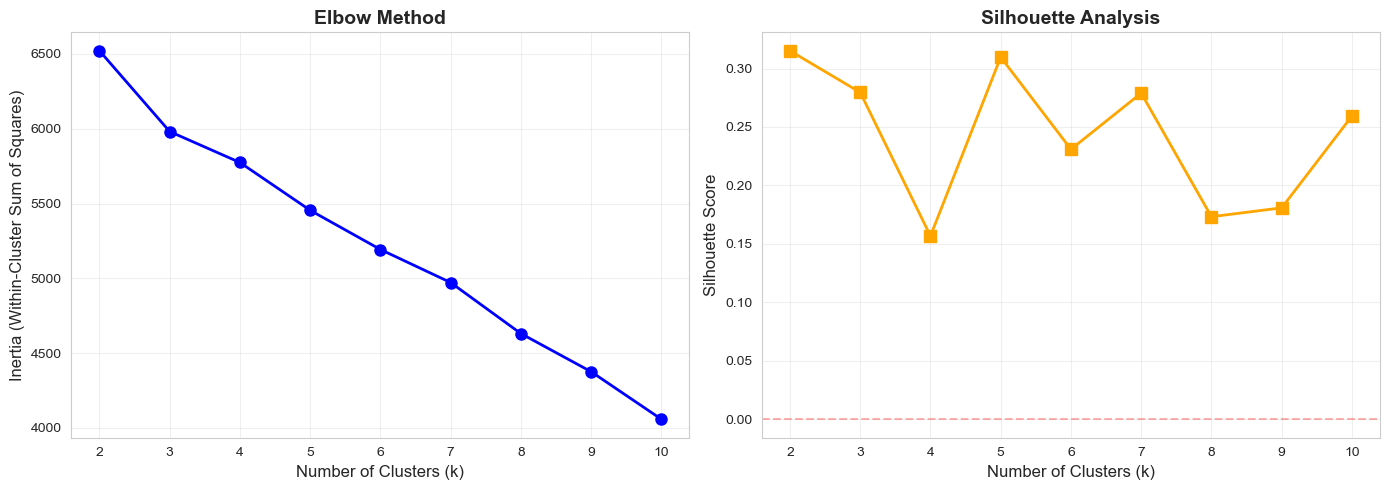


 HOW TO INTERPRET:
Elbow Method: Look for the 'elbow' (point where curve bends)
Silhouette: Higher is better (range: -1 to 1)

 Based on these plots, k=4 or k=5 seems reasonable


In [23]:
print(" Finding optimal number of clusters...\n")

# Try different k values
K_range = range(2, 11)
inertias = []
silhouette_scores = []

for k in K_range:
    # Fit K-Means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    
    # Calculate metrics
    inertias.append(kmeans.inertia_)
    sil_score = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(sil_score)
    
    print(f"k={k:2d}: Inertia={kmeans.inertia_:8.2f}, Silhouette={sil_score:.4f}")

# Plot results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Elbow plot
axes[0].plot(K_range, inertias, marker='o', linewidth=2, markersize=8, color='blue')
axes[0].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[0].set_ylabel('Inertia (Within-Cluster Sum of Squares)', fontsize=12)
axes[0].set_title('Elbow Method', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)
axes[0].set_xticks(K_range)

# Silhouette plot
axes[1].plot(K_range, silhouette_scores, marker='s', linewidth=2, markersize=8, color='orange')
axes[1].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Analysis', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)
axes[1].set_xticks(K_range)
axes[1].axhline(y=0, color='red', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print(" HOW TO INTERPRET:")
print("="*70)
print("Elbow Method: Look for the 'elbow' (point where curve bends)")
print("Silhouette: Higher is better (range: -1 to 1)")
print("\n Based on these plots, k=4 or k=5 seems reasonable")

---
## 🎯 Cell 9: Apply K-Means Clustering

**What this does:** Run K-Means with optimal k value (let's use k=4)

In [9]:
# Choose optimal k
optimal_k = 4

print(f" Running K-Means with k={optimal_k}...\n")

# Apply K-Means
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

# Calculate evaluation metrics
sil_score = silhouette_score(X_scaled, cluster_labels)
db_score = davies_bouldin_score(X_scaled, cluster_labels)

print("="*70)
print("CLUSTERING RESULTS")
print("="*70)
print(f"Number of clusters: {optimal_k}")
print(f"Silhouette Score: {sil_score:.4f} (higher is better, max=1)")
print(f"Davies-Bouldin Index: {db_score:.4f} (lower is better, min=0)")

# Add cluster labels to dataframe
student_df['cluster'] = cluster_labels

# Show cluster distribution
print("\n" + "="*70)
print("CLUSTER DISTRIBUTION")
print("="*70)
for cluster_id in range(optimal_k):
    count = (cluster_labels == cluster_id).sum()
    percentage = (count / len(cluster_labels)) * 100
    print(f"Cluster {cluster_id}: {count:3d} students ({percentage:5.1f}%)")

print("\n Clustering complete!")

 Running K-Means with k=4...

CLUSTERING RESULTS
Number of clusters: 4
Silhouette Score: 0.1568 (higher is better, max=1)
Davies-Bouldin Index: 1.8949 (lower is better, min=0)

CLUSTER DISTRIBUTION
Cluster 0: 107 students ( 39.5%)
Cluster 1:  65 students ( 24.0%)
Cluster 2:  98 students ( 36.2%)
Cluster 3:   1 students (  0.4%)

 Clustering complete!


---
##  Cell 10: DIMENSIONALITY REDUCTION - PCA for 2D Visualization

**What this does:** Reduce 26-dimensional data to 2D so we can plot it

**Key concept:** 
- We have 26 features (impossible to visualize)
- PCA finds the 2 most important directions
- Like taking a photo of a 3D object (you see 2D shadow)
- Clustering still happens in full 26D (accurate)!
- 2D is just for our eyes (approximate)

In [10]:
print(" Reducing dimensions for visualization...\n")

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print("="*70)
print("DIMENSIONALITY REDUCTION")
print("="*70)
print(f"Original dimensions: {X_scaled.shape[1]}D ({X_scaled.shape[1]} features)")
print(f"Reduced dimensions:  2D (for visualization)")
print(f"\nVariance explained by PC1: {pca.explained_variance_ratio_[0]*100:.2f}%")
print(f"Variance explained by PC2: {pca.explained_variance_ratio_[1]*100:.2f}%")
print(f"Total variance explained:  {sum(pca.explained_variance_ratio_)*100:.2f}%")

print("\n This means:")
print(f"   - These 2 dimensions capture {sum(pca.explained_variance_ratio_)*100:.1f}% of the variation")
print(f"   - Enough to see cluster structure!")
print(f"   - Remember: actual clustering used all {X_scaled.shape[1]} dimensions")

print(f"\n Data ready for plotting!")
print(f"   Shape after PCA: {X_pca.shape}")

 Reducing dimensions for visualization...

DIMENSIONALITY REDUCTION
Original dimensions: 26D (26 features)
Reduced dimensions:  2D (for visualization)

Variance explained by PC1: 9.67%
Variance explained by PC2: 7.93%
Total variance explained:  17.60%

 This means:
   - These 2 dimensions capture 17.6% of the variation
   - Enough to see cluster structure!
   - Remember: actual clustering used all 26 dimensions

 Data ready for plotting!
   Shape after PCA: (271, 2)


---
##  Cell 11: VISUALIZE CLUSTERS in 2D

**What this does:** Plot the clusters in 2D space

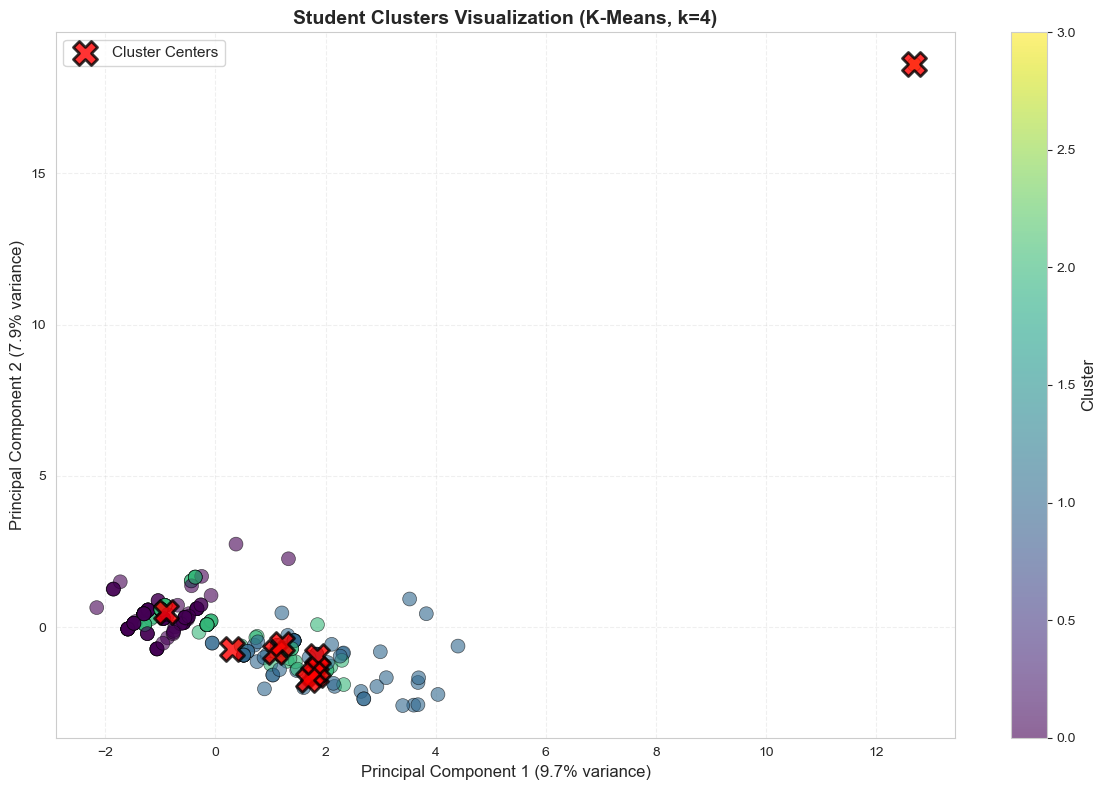

 2D visualization complete!

 What you see:
   - Each point is a student
   - Colors show cluster assignments
   - Red X marks are cluster centers
   - This is a 2D projection of 26D data!


In [25]:
# Create beautiful cluster visualization
plt.figure(figsize=(12, 8))

# Create scatter plot
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], 
                     c=cluster_labels, 
                     cmap='viridis', 
                     s=100, 
                     alpha=0.6, 
                     edgecolors='black', 
                     linewidth=0.5)

# Add cluster centers
centers_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], 
           c='red', 
           s=300, 
           alpha=0.8, 
           edgecolors='black', 
           linewidth=2, 
           marker='X',
           label='Cluster Centers')

# Labels and title
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)', 
          fontsize=12)
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)', 
          fontsize=12)
plt.title(f'Student Clusters Visualization (K-Means, k={optimal_k})', 
         fontsize=14, fontweight='bold')

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Cluster', fontsize=12)

# Add legend
plt.legend(fontsize=11)

# Grid
plt.grid(alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

print(" 2D visualization complete!")
print("\n What you see:")
print("   - Each point is a student")
print("   - Colors show cluster assignments")
print("   - Red X marks are cluster centers")
print("   - This is a 2D projection of 26D data!")

---
##  Cell 12: INTERPRET CLUSTERS - What do they mean?

**What this does:** Analyze each cluster to understand the student types

In [ ]:
print(" CLUSTER INTERPRETATION")
print("="*70)

for cluster_id in range(optimal_k):
    cluster_data = student_df[student_df['cluster'] == cluster_id]
    
    print(f"\n{'='*70}")
    print(f"CLUSTER {cluster_id} - {len(cluster_data)} students")
    print(f"{'='*70}")
    
    # Borrowing behavior
    print(f"\n Borrowing Behavior:")
    print(f"   Average books borrowed: {cluster_data['total_books_borrowed'].mean():.2f}")
    print(f"   Average duration:       {cluster_data['avg_borrowing_duration'].mean():.2f} days")
    print(f"   Max duration:           {cluster_data['max_borrowing_duration'].mean():.2f} days")
    print(f"   Topic diversity:        {cluster_data['topic_diversity'].mean():.2f} topics")
    
    # Student categories
    print(f"\n Student Categories:")
    category_dist = cluster_data['student_category'].value_counts()
    for cat, count in category_dist.items():
        percentage = (count / len(cluster_data)) * 100
        print(f"   {cat:15s}: {count:3d} students ({percentage:5.1f}%)")
    
    # Top topics
    print(f"\n  Top 5 Book Topics:")
    topic_cols = [col for col in student_df.columns if col.startswith('books_')]
    topic_sums = cluster_data[topic_cols].sum().sort_values(ascending=False)
    
    for i, (topic, count) in enumerate(topic_sums.head(5).items(), 1):
        topic_name = topic.replace('books_', '')
        print(f"   {i}. {topic_name[:40]:40s}: {int(count):3d} books")

print("\n" + "="*70)
print(" Cluster analysis complete!")

 CLUSTER INTERPRETATION


TypeError: 'NoneType' object is not subscriptable

---
##  Cell 13: Create Comprehensive Visualizations

**What this does:** Create multiple charts to understand clusters better

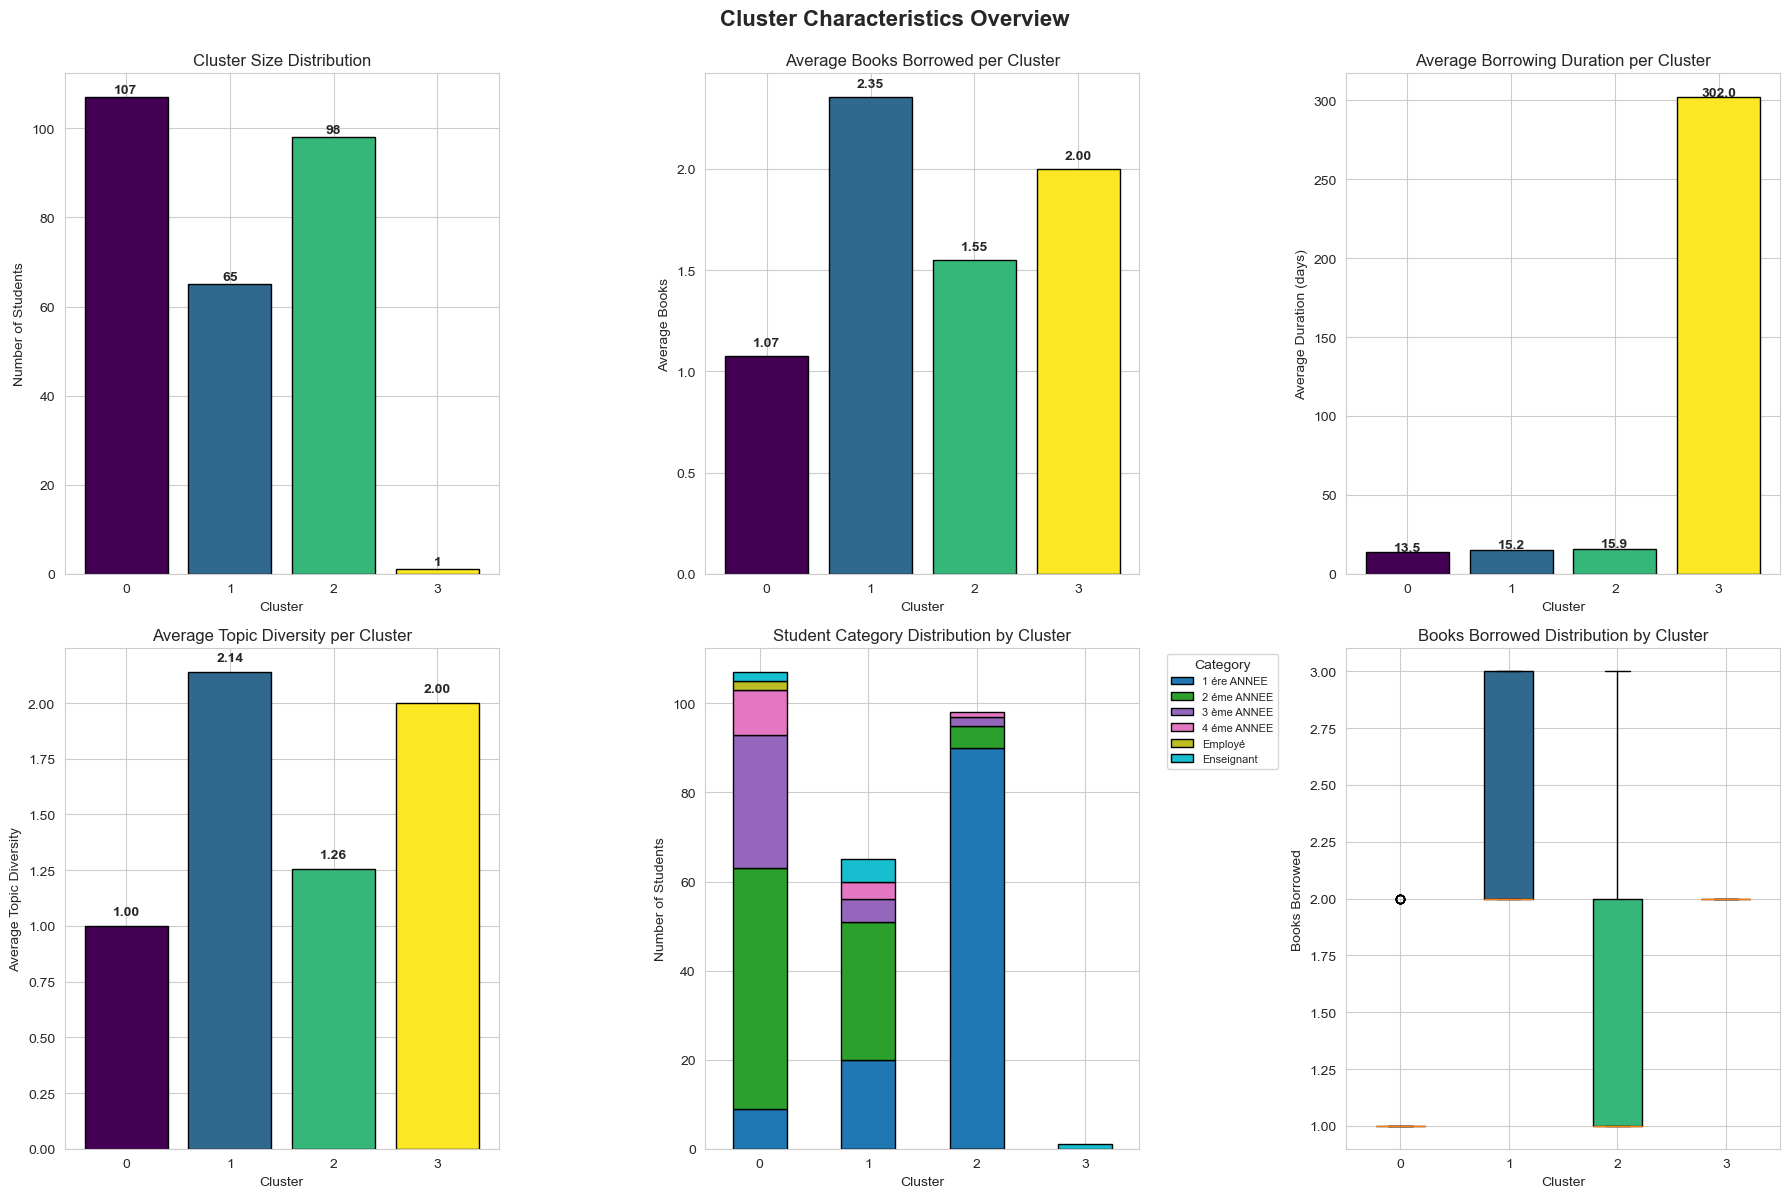

 Comprehensive visualizations created!


In [13]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Cluster Characteristics Overview', fontsize=16, fontweight='bold', y=0.995)

# 1. Cluster sizes
cluster_counts = student_df['cluster'].value_counts().sort_index()
colors = plt.cm.viridis(np.linspace(0, 1, optimal_k))
axes[0, 0].bar(cluster_counts.index, cluster_counts.values, color=colors, edgecolor='black')
axes[0, 0].set_xlabel('Cluster')
axes[0, 0].set_ylabel('Number of Students')
axes[0, 0].set_title('Cluster Size Distribution')
axes[0, 0].set_xticks(cluster_counts.index)
for i, v in enumerate(cluster_counts.values):
    axes[0, 0].text(i, v + 1, str(v), ha='center', fontweight='bold')

# 2. Average books borrowed
avg_books = student_df.groupby('cluster')['total_books_borrowed'].mean()
axes[0, 1].bar(avg_books.index, avg_books.values, color=colors, edgecolor='black')
axes[0, 1].set_xlabel('Cluster')
axes[0, 1].set_ylabel('Average Books')
axes[0, 1].set_title('Average Books Borrowed per Cluster')
axes[0, 1].set_xticks(avg_books.index)
for i, v in enumerate(avg_books.values):
    axes[0, 1].text(i, v + 0.05, f'{v:.2f}', ha='center', fontweight='bold')

# 3. Average duration
avg_duration = student_df.groupby('cluster')['avg_borrowing_duration'].mean()
axes[0, 2].bar(avg_duration.index, avg_duration.values, color=colors, edgecolor='black')
axes[0, 2].set_xlabel('Cluster')
axes[0, 2].set_ylabel('Average Duration (days)')
axes[0, 2].set_title('Average Borrowing Duration per Cluster')
axes[0, 2].set_xticks(avg_duration.index)
for i, v in enumerate(avg_duration.values):
    axes[0, 2].text(i, v + 1, f'{v:.1f}', ha='center', fontweight='bold')

# 4. Topic diversity
avg_diversity = student_df.groupby('cluster')['topic_diversity'].mean()
axes[1, 0].bar(avg_diversity.index, avg_diversity.values, color=colors, edgecolor='black')
axes[1, 0].set_xlabel('Cluster')
axes[1, 0].set_ylabel('Average Topic Diversity')
axes[1, 0].set_title('Average Topic Diversity per Cluster')
axes[1, 0].set_xticks(avg_diversity.index)
for i, v in enumerate(avg_diversity.values):
    axes[1, 0].text(i, v + 0.05, f'{v:.2f}', ha='center', fontweight='bold')

# 5. Student category distribution
category_cluster = pd.crosstab(student_df['cluster'], student_df['student_category'])
category_cluster.plot(kind='bar', stacked=True, ax=axes[1, 1], colormap='tab10', edgecolor='black')
axes[1, 1].set_xlabel('Cluster')
axes[1, 1].set_ylabel('Number of Students')
axes[1, 1].set_title('Student Category Distribution by Cluster')
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=0)
axes[1, 1].legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

# 6. Box plot of books borrowed
data_to_plot = [student_df[student_df['cluster'] == i]['total_books_borrowed'].values 
                for i in range(optimal_k)]
bp = axes[1, 2].boxplot(data_to_plot, patch_artist=True, labels=range(optimal_k))
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
axes[1, 2].set_xlabel('Cluster')
axes[1, 2].set_ylabel('Books Borrowed')
axes[1, 2].set_title('Books Borrowed Distribution by Cluster')

plt.tight_layout()
plt.show()

print(" Comprehensive visualizations created!")

---
##  Cell 14: Compare Different Clustering Algorithms

**What this does:** Try DBSCAN and Hierarchical clustering for comparison

 Comparing different clustering algorithms...

K-MEANS (k=4):
   Silhouette Score: 0.1568

HIERARCHICAL (k=4):
   Silhouette Score: 0.2233

DBSCAN (trying different eps values):
   eps=0.5: 18 clusters, 60 noise, Silhouette=0.6057
   eps=1.0: 17 clusters, 60 noise, Silhouette=0.6065
   eps=1.5: 18 clusters, 54 noise, Silhouette=0.6118
   eps=2.0: 18 clusters, 54 noise, Silhouette=0.6118
   eps=2.5: 14 clusters, 42 noise, Silhouette=0.3816
   eps=3.0: 8 clusters, 35 noise, Silhouette=0.3146


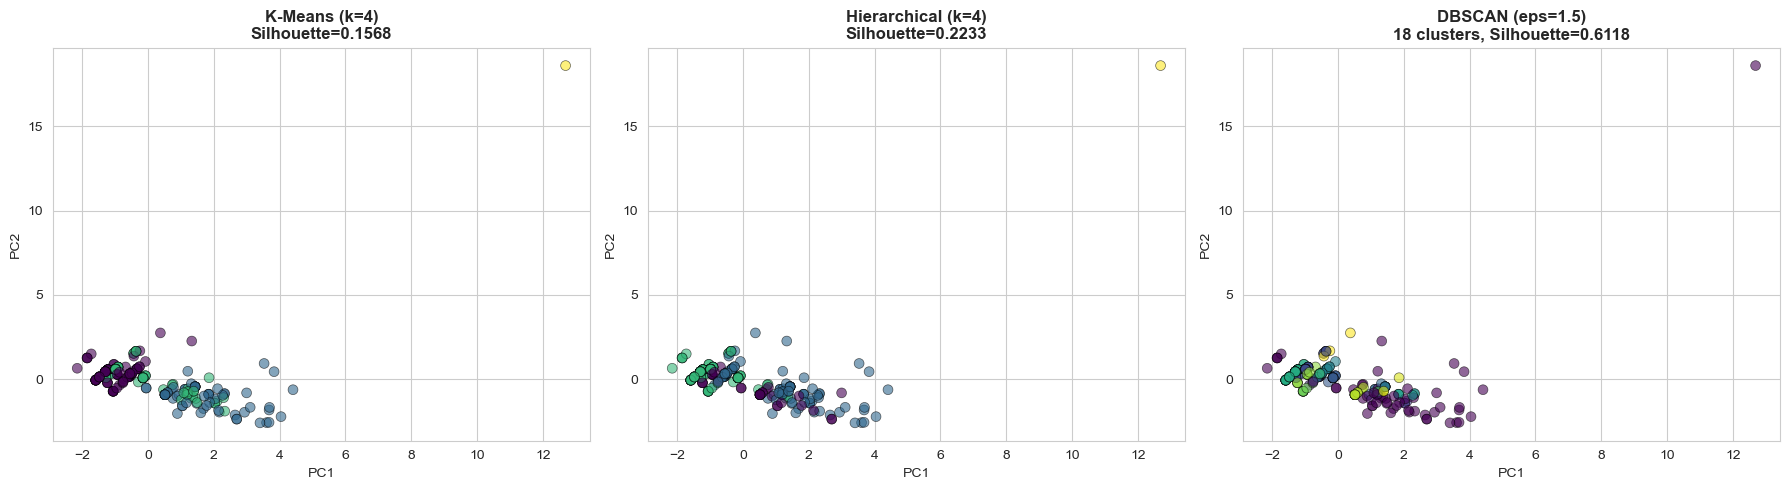


RECOMMENDATION:
 Hierarchical clustering performs better!


In [28]:
print(" Comparing different clustering algorithms...\n")

# 1. K-Means (already done)
kmeans_sil = silhouette_score(X_scaled, cluster_labels)
print(f"K-MEANS (k={optimal_k}):")
print(f"   Silhouette Score: {kmeans_sil:.4f}")

# 2. Hierarchical Clustering
hierarchical = AgglomerativeClustering(n_clusters=optimal_k)
hierarchical_labels = hierarchical.fit_predict(X_scaled)
hierarchical_sil = silhouette_score(X_scaled, hierarchical_labels)
print(f"\nHIERARCHICAL (k={optimal_k}):")
print(f"   Silhouette Score: {hierarchical_sil:.4f}")

# 3. DBSCAN
print(f"\nDBSCAN (trying different eps values):")
best_eps = None
best_dbscan_sil = -1
best_dbscan_labels = None

for eps in [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]:
    dbscan = DBSCAN(eps=eps, min_samples=3)
    dbscan_labels = dbscan.fit_predict(X_scaled)
    
    n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
    n_noise = list(dbscan_labels).count(-1)
    
    if n_clusters > 1 and n_noise < len(dbscan_labels) * 0.5:
        dbscan_sil = silhouette_score(X_scaled, dbscan_labels)
        print(f"   eps={eps}: {n_clusters} clusters, {n_noise} noise, Silhouette={dbscan_sil:.4f}")
        
        if dbscan_sil > best_dbscan_sil:
            best_dbscan_sil = dbscan_sil
            best_eps = eps
            best_dbscan_labels = dbscan_labels

# Visualize all three
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# K-Means
axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis', 
               s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
axes[0].set_title(f'K-Means (k={optimal_k})\nSilhouette={kmeans_sil:.4f}', fontweight='bold')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')

# Hierarchical
axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=hierarchical_labels, cmap='viridis', 
               s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
axes[1].set_title(f'Hierarchical (k={optimal_k})\nSilhouette={hierarchical_sil:.4f}', fontweight='bold')
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')

# DBSCAN
if best_dbscan_labels is not None:
    axes[2].scatter(X_pca[:, 0], X_pca[:, 1], c=best_dbscan_labels, cmap='viridis', 
                   s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
    n_clusters_dbscan = len(set(best_dbscan_labels)) - (1 if -1 in best_dbscan_labels else 0)
    axes[2].set_title(f'DBSCAN (eps={best_eps})\n{n_clusters_dbscan} clusters, Silhouette={best_dbscan_sil:.4f}', 
                     fontweight='bold')
axes[2].set_xlabel('PC1')
axes[2].set_ylabel('PC2')

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("RECOMMENDATION:")
print("="*70)
if kmeans_sil >= hierarchical_sil and kmeans_sil >= best_dbscan_sil:
    print(" K-Means performs best for this data!")
elif hierarchical_sil > kmeans_sil:
    print(" Hierarchical clustering performs better!")
else:
    print(" DBSCAN performs best but creates many clusters")
    print("   K-Means might be more practical for library recommendations")

---
##  Cell 15: Save Results

**What this does:** Export clustered data and summary statistics

In [29]:
print(" Saving results...\n")

# 1. Save student clusters
student_df.to_csv('student_clusters.csv', index=False)
print(" Saved: student_clusters.csv")
print(f"   Contains: {len(student_df)} students with cluster assignments")

# 2. Create and save cluster summary
summary = student_df.groupby('cluster').agg({
    'total_books_borrowed': ['mean', 'std', 'min', 'max'],
    'avg_borrowing_duration': ['mean', 'std'],
    'topic_diversity': ['mean', 'std'],
    'student_id': 'count'
}).round(2)

summary.columns = ['_'.join(col).strip() for col in summary.columns.values]
summary = summary.rename(columns={'student_id_count': 'num_students'})
summary.to_csv('cluster_summary.csv')
print("\n Saved: cluster_summary.csv")
print("   Contains: Statistical summary for each cluster")

# Display summary
print("\n" + "="*70)
print("CLUSTER SUMMARY")
print("="*70)
print(summary)

print("\n" + "="*70)
print(" ALL RESULTS SAVED!")
print("="*70)
print("\nYou can now use these files for:")
print("  • Personalized book recommendations")
print("  • Library collection planning")
print("  • Student engagement strategies")
print("  • Understanding reading patterns")

 Saving results...



AttributeError: 'NoneType' object has no attribute 'to_csv'

---
##  Cell 16: Summary & Next Steps

**What we accomplished:**

In [17]:
print("="*70)
print(" CLUSTERING ANALYSIS COMPLETE!")
print("="*70)

print("\n What we did:")
print("   1. Loaded library borrowing data")
print("   2. Converted STRING features to NUMBERS (feature engineering)")
print("   3. STANDARDIZED data (solved distance problem)")
print("   4. Determined optimal k (elbow method + silhouette)")
print("   5. Applied K-Means clustering")
print("   6. Reduced to 2D using PCA (for visualization)")
print("   7. Visualized clusters")
print("   8. Interpreted cluster meanings")
print("   9. Compared different algorithms")
print("   10. Saved results")

print("\n Key Findings:")
print(f"   • Found {optimal_k} distinct student clusters")
print(f"   • Silhouette Score: {kmeans_sil:.4f}")
print(f"   • Clusters align with student years and reading patterns")

print("\n Practical Applications:")
print("   • Personalize book recommendations by cluster")
print("   • Order more books for high-demand topics per cluster")
print("   • Create targeted reading programs")
print("   • Identify students who need more engagement")

print("\n Key Concepts You Learned:")
print("   ✓ Clustering vs Classification (unsupervised vs supervised)")
print("   ✓ Feature engineering (strings → numbers)")
print("   ✓ Standardization (solving distance problem)")
print("   ✓ Determining k (elbow method, silhouette)")
print("   ✓ PCA (high dimensions → 2D visualization)")
print("   ✓ K-Means, DBSCAN, Hierarchical clustering")

print("\n Next Steps:")
print("   1. Try different k values")
print("   2. Add more features (e.g., time of year, day of week)")
print("   3. Create recommendation system based on clusters")
print("   4. Re-run clustering periodically to track changes")


 CLUSTERING ANALYSIS COMPLETE!

 What we did:
   1. Loaded library borrowing data
   2. Converted STRING features to NUMBERS (feature engineering)
   3. STANDARDIZED data (solved distance problem)
   4. Determined optimal k (elbow method + silhouette)
   5. Applied K-Means clustering
   6. Reduced to 2D using PCA (for visualization)
   7. Visualized clusters
   8. Interpreted cluster meanings
   9. Compared different algorithms
   10. Saved results

 Key Findings:
   • Found 4 distinct student clusters
   • Silhouette Score: 0.1568
   • Clusters align with student years and reading patterns

 Practical Applications:
   • Personalize book recommendations by cluster
   • Order more books for high-demand topics per cluster
   • Create targeted reading programs
   • Identify students who need more engagement

 Key Concepts You Learned:
   ✓ Clustering vs Classification (unsupervised vs supervised)
   ✓ Feature engineering (strings → numbers)
   ✓ Standardization (solving distance problem)


## Testing

In [ ]:
# SIMPLE TEST CELL: check k-means clustering result

import numpy as np

# 0) Make sure the model and data are ready
try:
    X_scaled
    kmeans
except NameError:
    raise RuntimeError("Run all cells up to the clustering (KMeans) part before this test cell.")

print("="*60)
print("RANDOM STUDENT CLUSTER TEST (USING ONLY X_scaled + kmeans)")
print("="*60)

# 1) pick a random row from X_scaled
random_idx = np.random.randint(0, X_scaled.shape[0])
print(f"Row index in X_scaled: {random_idx}")

# 2) show the standardized feature vector
print("\nStandardized feature vector (X_scaled[random_idx]):")
print(X_scaled[random_idx])

# 3) get the predicted cluster
student_cluster = kmeans.labels_[random_idx]
print(f"\nAssigned cluster label by K-Means: {student_cluster}")

print("\n Re-run this cell to test another random student.")


RANDOM STUDENT CLUSTER TEST (USING ONLY X_scaled + kmeans)
Row index in X_scaled: 213

Standardized feature vector (X_scaled[random_idx]):
[-0.80183145 -0.0472685  -0.05385712 -0.65849354 -0.67762495 -0.31975622
 -0.12239801  0.64766309 -0.09968896 -0.44076187 -0.27458482 -0.35201222
 -0.1671258  -0.13710212 -0.06085806 -0.17515568 -0.08622612 -0.06085806
 -0.06085806 -0.08622612 -0.06085806 -0.06085806 -0.06085806 -0.06085806
 -0.06085806 -0.06085806]

Assigned cluster label by K-Means: 2

 Re-run this cell to test another random student.
